# 基于英雄联盟数据集的LightGBM分类实践

* 特征：<br>
WardsPlaced 插眼数量 整数<br>
WardsDestroyed 拆眼数量 整数<br>
FirstBlood 是否获得首次击杀 整数<br>
Kills 击杀英雄数量 整数<br>
Deaths 死亡数量 整数<br>
Assists 助攻数量 整数<br>
EliteMonsters 击杀大型野怪数量 整数<br>
Deagons 击杀史诗级野怪数量 整数<br>
Heralds 击杀峡谷先锋数量 整数<br>
TowersDestroyed 推塔数量 整数<br>
TotalGold 总经济 整数<br>
AvgLevel 平均英雄等级 浮点数<br>
TotalExperience 英雄总经验 整数<br>
TotalMinionsKilled 英雄补兵数量 整数<br>
TotalJungleMinionsKilled 英雄击杀野怪数量 整数<br>
GoldDiff 经济差距 整数<br>
ExperienceDiff 经验差距 整数<br>
CSPerMin 分均补刀 浮点数<br>
GoldPerMin 分均经济 浮点数<br>
* 标签：blueWins（是否为蓝队获胜）

In [2]:
!wget https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/8LightGBM/high_diamond_ranked_10min.csv

--2023-07-11 03:16:21--  https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/8LightGBM/high_diamond_ranked_10min.csv
Resolving tianchi-media.oss-cn-beijing.aliyuncs.com (tianchi-media.oss-cn-beijing.aliyuncs.com)... 59.110.185.93
Connecting to tianchi-media.oss-cn-beijing.aliyuncs.com (tianchi-media.oss-cn-beijing.aliyuncs.com)|59.110.185.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1446502 (1.4M) [text/csv]
Saving to: ‘high_diamond_ranked_10min.csv’

high_diamond_ranked 100%[===================>]   1.38M   972KB/s    in 1.5s    

2023-07-11 03:16:24 (972 KB/s) - ‘high_diamond_ranked_10min.csv’ saved [1446502/1446502]



### Step1:函数库导入

In [3]:
#基础函数库
import numpy as np
import pandas as pd

#绘图函数库
import matplotlib.pyplot as plt
import seaborn as sns

### Step2:数据读取/导入

In [4]:
df=pd.read_csv('./high_diamond_ranked_10min.csv')
df.head()
y=df.blueWins #数据的标签，同时也是我们需要预测的值

### Step3:数据信息简单查看

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [6]:
#查看blue的信息
df_blue=df.iloc[:,0:21]
df_blue

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,...,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,...,0,17765,7.2,18967,211,69,2519,2469,21.1,1776.5
9875,4527797466,1,54,0,0,6,4,8,1,1,...,0,16238,7.2,19255,233,48,782,888,23.3,1623.8
9876,4527713716,0,23,1,0,6,7,5,0,0,...,0,15903,7.0,18032,210,45,-2416,-1877,21.0,1590.3
9877,4527628313,0,14,4,1,2,3,3,1,1,...,0,14459,6.6,17229,224,48,-839,-1085,22.4,1445.9


In [7]:
#查看red的信息
df_red=df.iloc[:,21:40]
df_red

,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,46,3,0,4,7,7,0,0,0,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,12,21,1,4,6,3,0,0,0,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,14,0,1,7,6,11,1,1,0,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,66,4,0,3,2,1,0,0,0,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


我们可以对比df_red与df_blue<br>
* redFirstBlood为0时，blueFirstBlood则为1
* EliteMonsters=Deagons+Heralds
* redGoldDiff=-blueGoldDiff
* redExperienceDiff=-blueExperienceDiff
* 不同对局中插眼数量有很大的差距，甚至有max为250的

In [8]:
df.tail()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
9874,4527873286,1,17,2,1,7,4,5,1,1,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,4527797466,1,54,0,0,6,4,8,1,1,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,4527713716,0,23,1,0,6,7,5,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8
9878,4523772935,1,18,0,1,6,6,5,0,0,...,0,15339,6.8,17379,201,46,-927,58,20.1,1533.9


In [9]:
#我们查看一下标签的情况
y.value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

数据集正负标签数量基本相同，不存在数据不平衡的问题

In [10]:
#标注特征列
drop_cols=['gameId','blueWins']
x=df.drop(drop_cols,axis=1)
#x为特征值，y为标签值，其中的gameId为没有用的信息

In [11]:
x

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,28,2,1,9,6,11,0,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,12,1,0,5,5,5,0,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,15,0,0,7,11,4,1,1,0,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,43,1,0,4,5,5,1,0,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,75,4,0,6,6,6,0,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,17,2,1,7,4,5,1,1,0,0,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,54,0,0,6,4,8,1,1,0,0,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,23,1,0,6,7,5,0,0,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,14,4,1,2,3,3,1,1,0,0,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


In [12]:
x.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


我们通过上述可以发现:<br>
TotalGold等变量在大部分对局中的差异不大<br>
ps:std为标准偏差，标准偏差越小，代表这些值偏离平均值就越少

In [13]:
#我们去除一些重复变量
#eg：蓝队拿到firstblood后，我们就知道红队没有firstblood
drop_cols=['redFirstBlood','redKills','redDeaths','redGoldDiff','redExperienceDiff','blueCSPerMin','blueGoldPerMin','redCSPerMin','redGoldPerMin']
x.drop(drop_cols,axis=1,inplace=True)
x

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,28,2,1,9,6,11,0,0,0,0,...,8,0,0,0,0,16567,6.8,17047,197,55
1,12,1,0,5,5,5,0,0,0,0,...,2,2,1,1,1,17620,6.8,17438,240,52
2,15,0,0,7,11,4,1,1,0,0,...,14,0,0,0,0,17285,6.8,17254,203,28
3,43,1,0,4,5,5,1,0,1,0,...,10,0,0,0,0,16478,7.0,17961,235,47
4,75,4,0,6,6,6,0,0,0,0,...,7,1,1,0,0,17404,7.0,18313,225,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,17,2,1,7,4,5,1,1,0,0,...,7,0,0,0,0,15246,6.8,16498,229,34
9875,54,0,0,6,4,8,1,1,0,0,...,3,0,0,0,0,15456,7.0,18367,206,56
9876,23,1,0,6,7,5,0,0,0,0,...,11,1,1,0,0,18319,7.4,19909,261,60
9877,14,4,1,2,3,3,1,1,0,0,...,1,0,0,0,0,15298,7.2,18314,247,40


### Step4:可视化描述

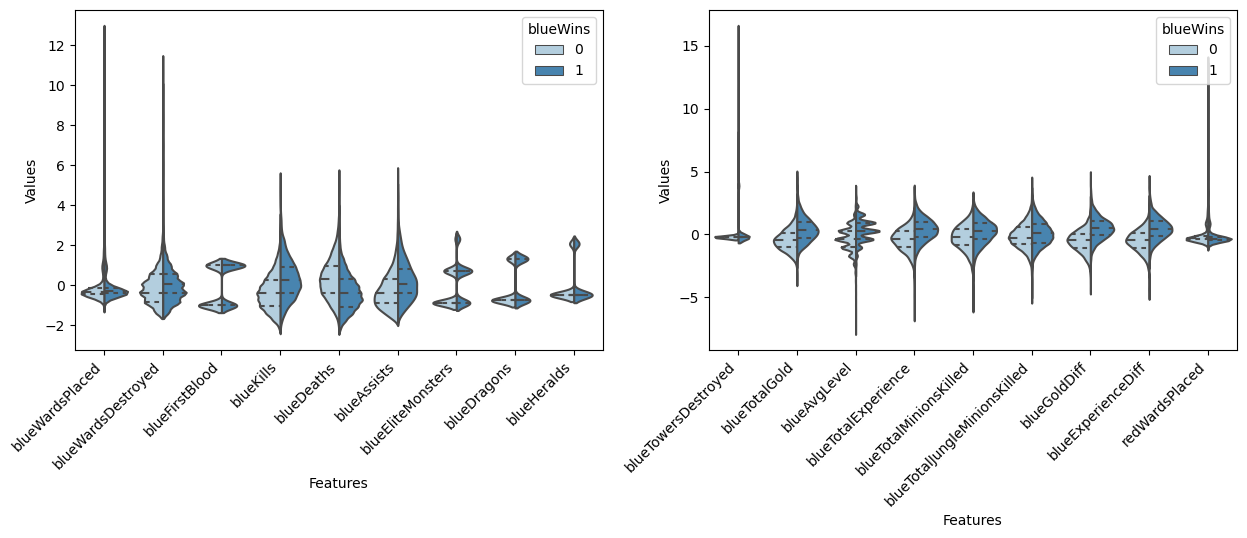

In [14]:
data=x
data_std1=(data-data.mean())/data.std() #经过标准化后的data
data=pd.concat([y,data_std1.iloc[:,0:9]],axis=1)
data=pd.melt(data,id_vars='blueWins',var_name='Features',value_name='Values')

fig,ax=plt.subplots(1,2,figsize=(15,5))

#绘制小提琴图
sns.violinplot(x='Features',y='Values',hue='blueWins',data=data,split=True,inner='quart',ax=ax[0],palette='Blues')
fig.autofmt_xdate(rotation=45)

#原来给出的代码有问题！！应该按照以下代码绘制第二张图
data=x
data_std2=(data-data.mean())/data.std()
data=pd.concat([y,data_std2.iloc[:,9:18]],axis=1)
data=pd.melt(data,id_vars='blueWins',var_name='Features',value_name='Values')

#绘制小提琴图
sns.violinplot(x='Features',y='Values',hue='blueWins',data=data,split=True,inner='quart',ax=ax[1],palette='Blues')
fig.autofmt_xdate(rotation=45)

plt.show()

小提琴图可以展示多组数据的分布状态以及概率密度，结合了箱型图和密度图的特征，主要用来显示数据的分布形状。

#### 小提琴图的解读
* `宽度`：小提琴图中的每个小提琴代表了数据在一个特定类别或分组上的分布情况。宽度可以反映该类别或分组中的样本数量，宽度越大表示样本数量越多。

* `中间的粗线`：中间的粗线代表数据的中位数，可以用来了解数据的中心趋势。

* `边界线`：小提琴图的边界线表示数据的范围，从最小值到最大值。如果边界线宽度较宽，表示数据在该范围内分布较广。

* `白点`：小提琴图中的白点表示数据的均值或其他统计指标，可以提供额外的信息。

* `核密度估计曲线`：小提琴图中的宽度越大，表示该类别或分组的数据分布越广泛。核密度估计曲线可以帮助你了解数据在不同值上的密度分布情况。

通过解读小提琴图我们可以得到以下信息：<br>
* 击杀英雄数量（blueKills）越多则越容易赢
* 死亡数量（blueDeaths）越多则越容易输
* 一血（blueFirstBlood）与获胜有正相关的关系
* 经济差（blueGoldDiff）与经验差（blueExperienceDiff）对游戏胜负对影响较大
* 击杀野怪数量对游戏胜负的影响不大

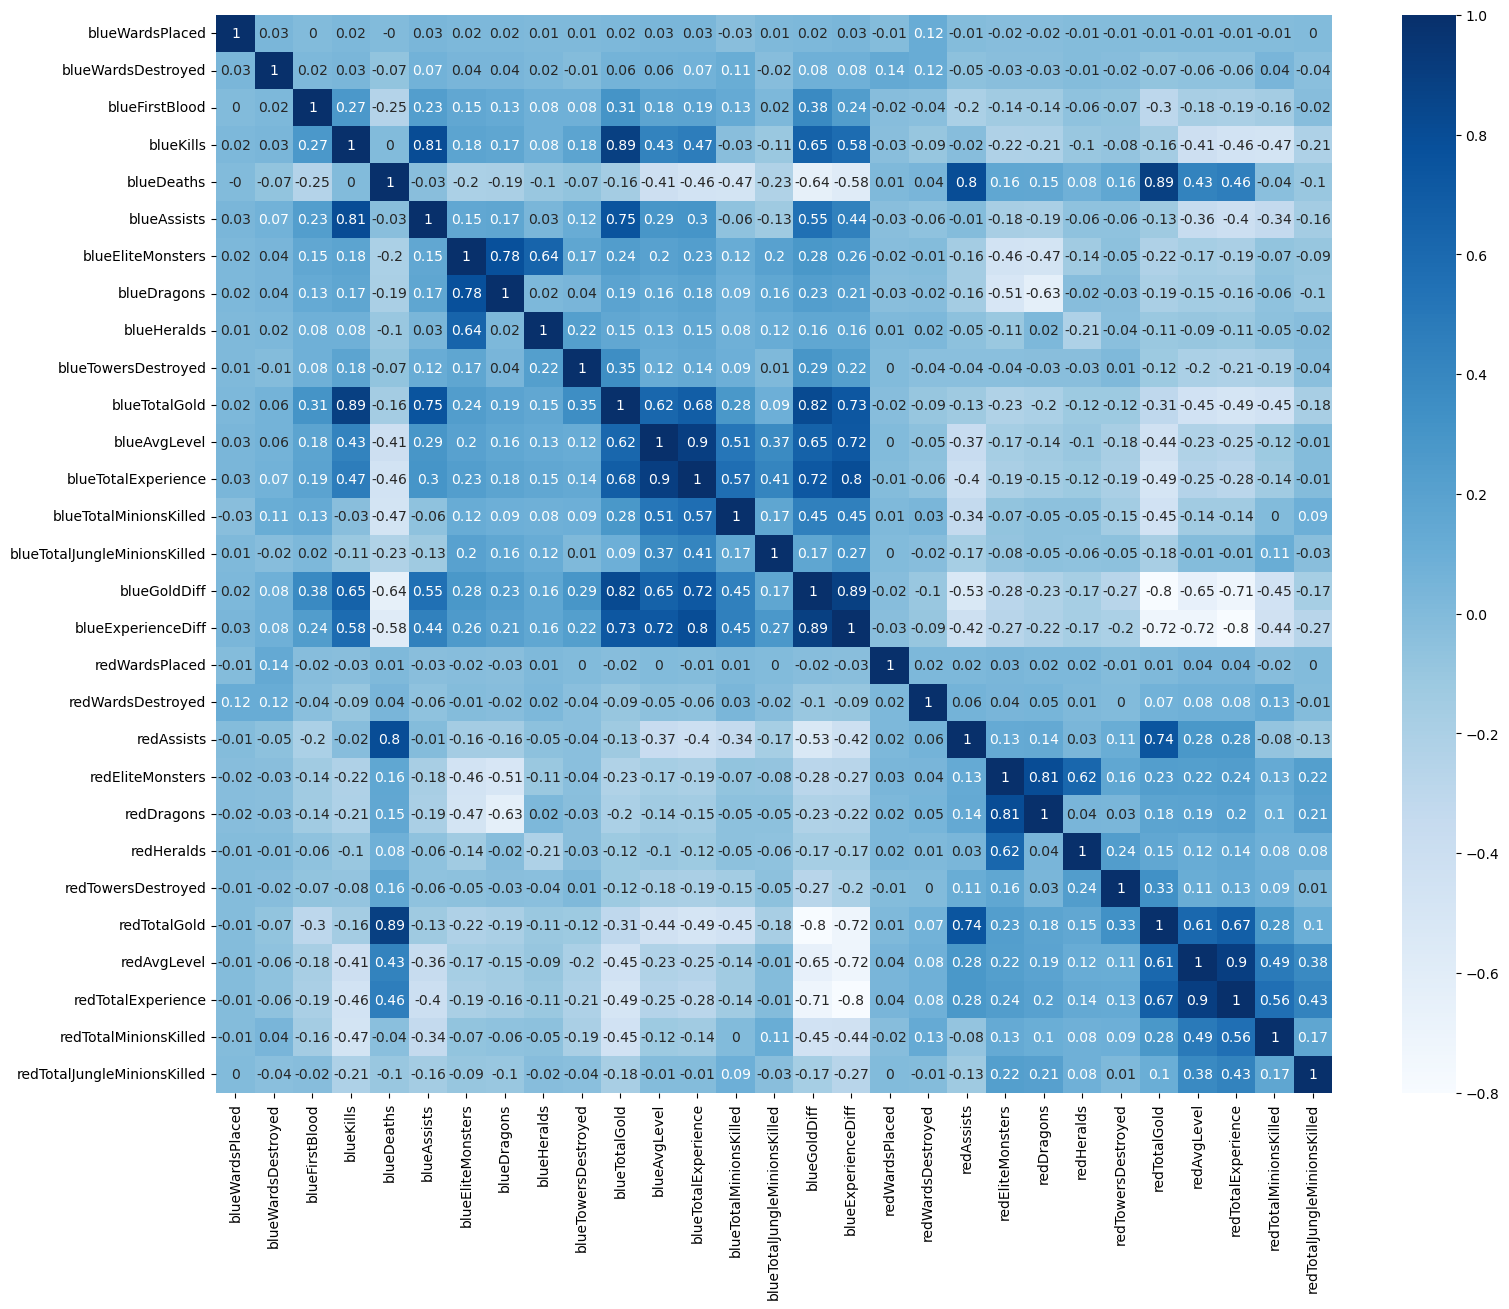

In [15]:
plt.figure(figsize=(18,14))
sns.heatmap(round(x.corr(),2),cmap='Blues',annot=True)
plt.show()

热力图：颜色越深则代表特征之间的相关性越强，我们需要剔除相关性较强的冗余特征

In [16]:
#去除冗余特征
drop_cols=['redAvgLevel','blueAvgLevel']
x.drop(drop_cols,axis=1,inplace=True)

In [20]:
sns.set(style='whitegrid',palette='muted')

#构造两个新特征
x['wardsPlaceDiff']=x['blueWardsPlaced']-x['redWardsPlaced']
x['wardsDestroyedDiff']=x['blueWardsDestroyed']-x['redWardsDestroyed']
x

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,wardsPlaceDiff,wardsDestroyedDiff
0,28,2,1,9,6,11,0,0,0,0,...,0,0,0,0,16567,17047,197,55,13,-4
1,12,1,0,5,5,5,0,0,0,0,...,2,1,1,1,17620,17438,240,52,0,0
2,15,0,0,7,11,4,1,1,0,0,...,0,0,0,0,17285,17254,203,28,0,-3
3,43,1,0,4,5,5,1,0,1,0,...,0,0,0,0,16478,17961,235,47,28,-1
4,75,4,0,6,6,6,0,0,0,0,...,1,1,0,0,17404,18313,225,67,58,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,17,2,1,7,4,5,1,1,0,0,...,0,0,0,0,15246,16498,229,34,-29,-1
9875,54,0,0,6,4,8,1,1,0,0,...,0,0,0,0,15456,18367,206,56,42,-21
9876,23,1,0,6,7,5,0,0,0,0,...,1,1,0,0,18319,19909,261,60,9,1
9877,14,4,1,2,3,3,1,1,0,0,...,0,0,0,0,15298,18314,247,40,-52,0


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 74.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 78.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 64.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 77.3% of the points cannot be plac

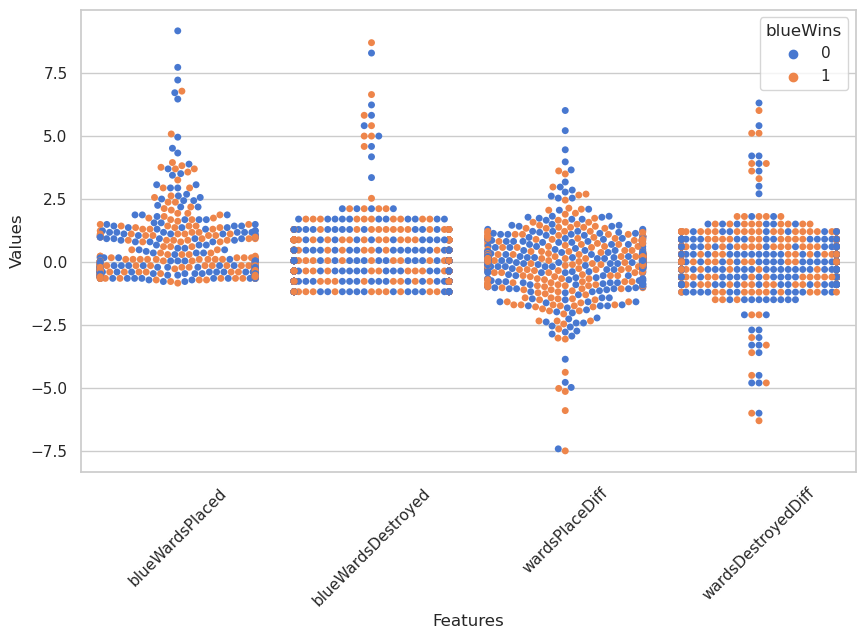

In [24]:
#选择x中的1000个样本生成x
data = x[['blueWardsPlaced','blueWardsDestroyed','wardsPlaceDiff','wardsDestroyedDiff']].sample(1000)
data_std = (data - data.mean()) / data.std() #进行标准化
data = pd.concat([y, data_std], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

plt.figure(figsize=(10,6))
sns.swarmplot(x='Features', y='Values', hue='blueWins', data=data)
plt.xticks(rotation=45)
plt.show()

上图为插眼数量的散点图，不存在插眼数量与游戏胜负之间的显著规律——>数据中前十分钟插眼数拔眼数对游戏的影响不大——>暂时去掉这些特征

In [26]:
#去除与眼位相关的特征
drop_cols=['blueWardsPlaced','blueWardsDestroyed','wardsPlaceDiff','wardsDestroyedDiff','redWardsPlaced','redWardsDestroyed']
x.drop(drop_cols,axis=1,inplace=True)

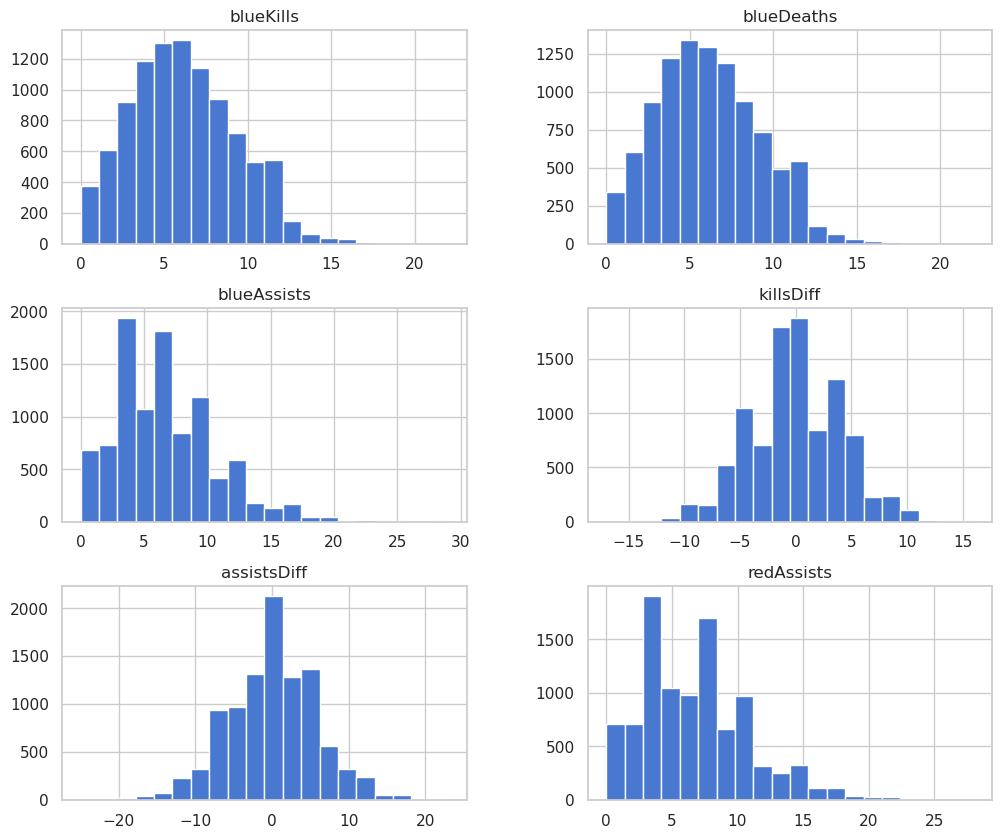

In [28]:
x['killsDiff']=x['blueKills']-x['blueDeaths']
x['assistsDiff']=x['blueAssists']-x['redAssists']

x[['blueKills','blueDeaths','blueAssists','killsDiff','assistsDiff','redAssists']].hist(figsize=(12,10),bins=20)
plt.show()

上述为击杀、死亡与助攻数的数据分布，我们可以发现这些数据分布的差别不大<br>
但是击杀减去死亡、助攻减去死亡的分布与原分布的差别很大

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 78.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 78.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 73.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 68.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 59.8% of the points cannot be plac

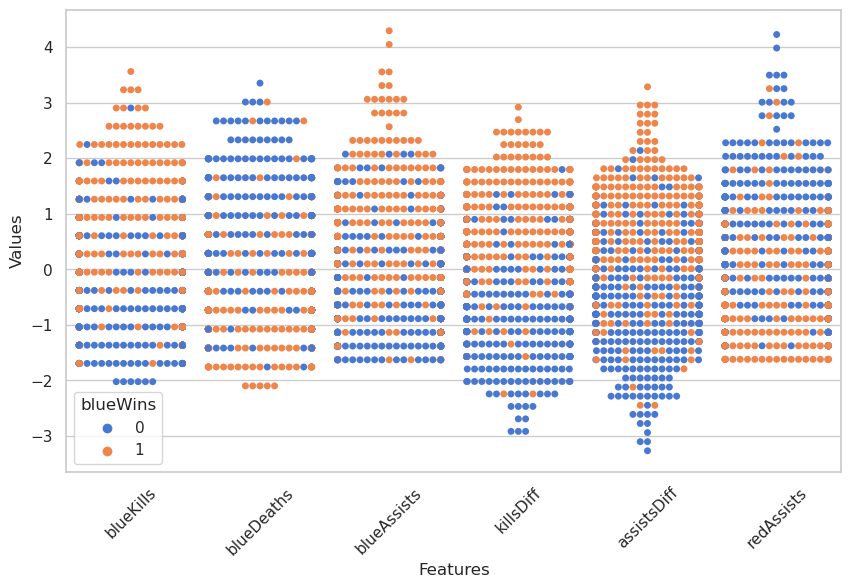

In [30]:
data = x[['blueKills','blueDeaths','blueAssists','killsDiff','assistsDiff','redAssists']].sample(1000)
#从上述特定列中随机抽取1000行，创建一个名为“data”的新dataframe
data_std = (data - data.mean()) / data.std() #计算标准化后的值
data = pd.concat([y, data_std], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values') #对dataframe进行重塑

plt.figure(figsize=(10,6))
sns.swarmplot(x='Features', y='Values', hue='blueWins', data=data)
plt.xticks(rotation=45)
plt.show()

由上图可以发现，击杀数与死亡数与助攻数，以及我们构造的特征killsDiff,assistsDiff都对数据有比较好的分类能力

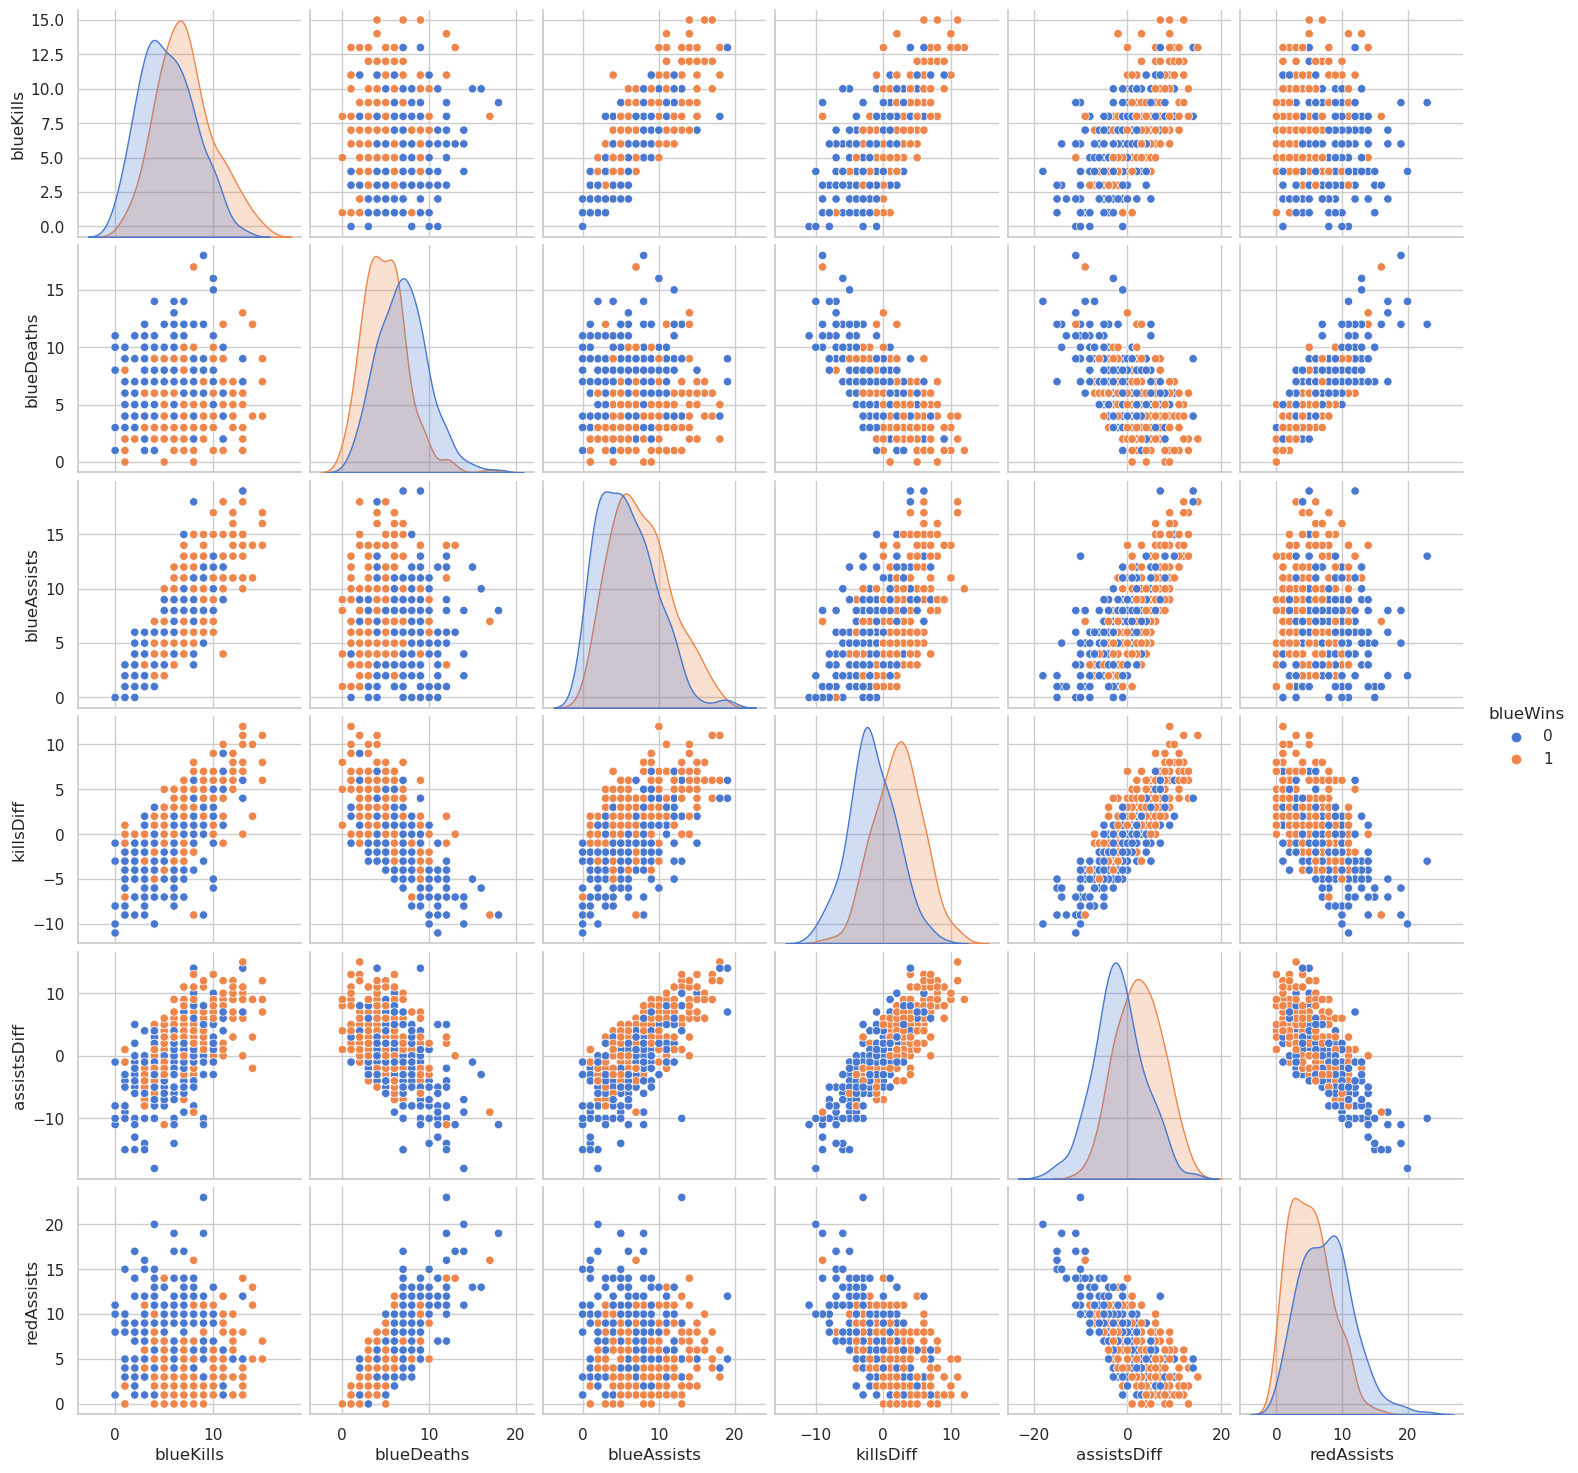

In [32]:
data=pd.concat([y,x],axis=1).sample(500)
sns.pairplot(data,vars=['blueKills','blueDeaths','blueAssists','killsDiff','assistsDiff','redAssists'],hue='blueWins')
plt.show()

eliteDiff
-2    0.286301
-1    0.368772
 0    0.500683
 1    0.632093
 2    0.735211
Name: blueWins, dtype: float64
dragonsDiff
-1    0.374173
 0    0.500000
 1    0.640940
Name: blueWins, dtype: float64
heraldsDiff
-1    0.387729
 0    0.498680
 1    0.595046
Name: blueWins, dtype: float64


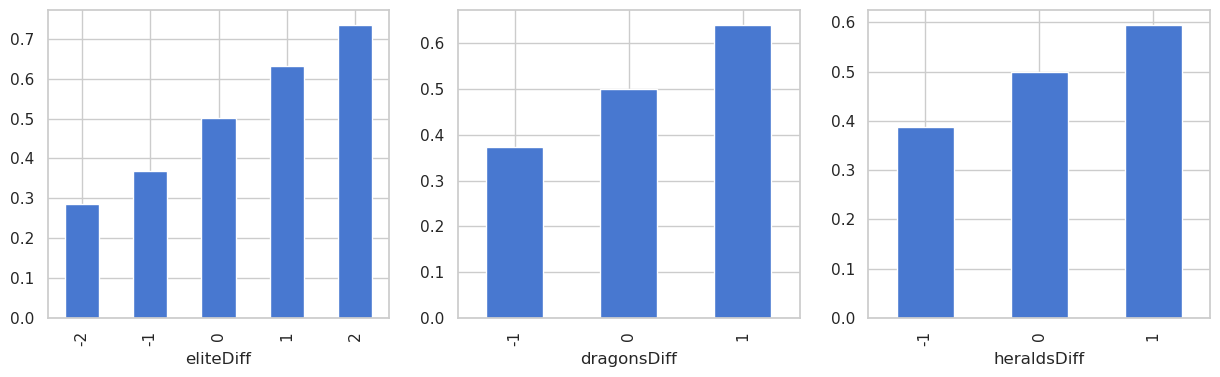

In [33]:
x['dragonsDiff']=x['blueDragons']-x['redDragons']
x['heraldsDiff']=x['blueHeralds']-x['redHeralds']
x['eliteDiff']=x['blueEliteMonsters']-x['redEliteMonsters']

data=pd.concat([y,x],axis=1)

eliteGroup=data.groupby(['eliteDiff'])['blueWins'].mean()
dragonGroup=data.groupby(['dragonsDiff'])['blueWins'].mean()
heraldGroup=data.groupby(['heraldsDiff'])['blueWins'].mean()

fig,ax=plt.subplots(1,3,figsize=(15,4))

eliteGroup.plot(kind='bar',ax=ax[0])
dragonGroup.plot(kind='bar',ax=ax[1])
heraldGroup.plot(kind='bar',ax=ax[2])

print(eliteGroup)
print(dragonGroup)
print(heraldGroup)

plt.show()

构造两队之间是否拿到龙、是否拿到峡谷先锋、击杀大型野怪的数量差值<br>
在游戏的前期拿到龙比拿到峡谷先锋更容易获得胜利<br>
拿到大型野怪的数量也与胜率有强相关的关系

towerDiff
-2      27
-1     347
 0    9064
 1     406
 2      28
 3       6
 4       1
Name: blueWins, dtype: int64
towerDiff
-2    0.185185
-1    0.216138
 0    0.498124
 1    0.741379
 2    0.964286
 3    1.000000
 4    1.000000
Name: blueWins, dtype: float64


Text(0.5, 1.0, 'Count')

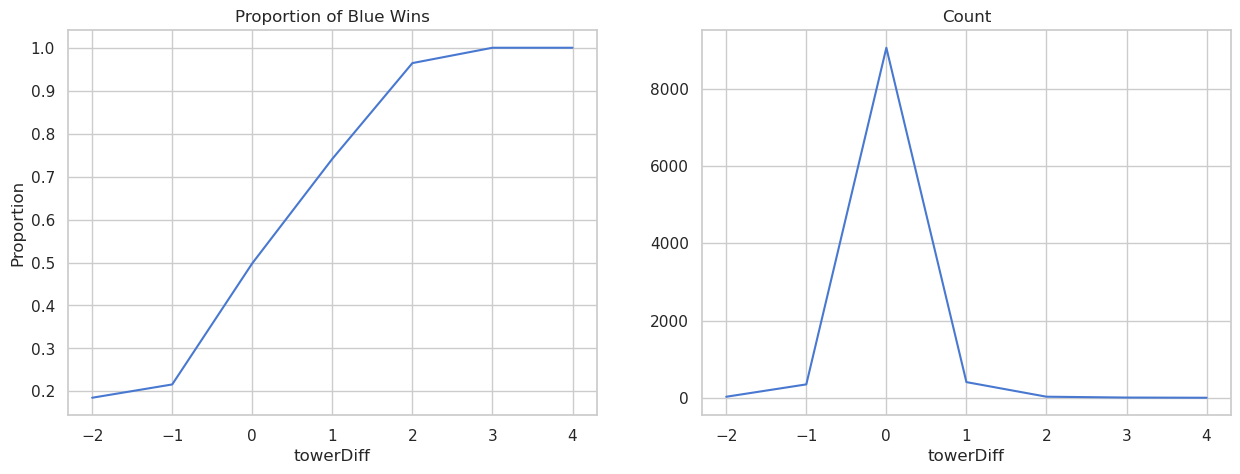

In [35]:
x['towerDiff']=x['blueTowersDestroyed']-x['redTowersDestroyed']
data=pd.concat([y,x],axis=1)

towerGroup=data.groupby(['towerDiff'])['blueWins']
print(towerGroup.count())
print(towerGroup.mean())

fig,ax=plt.subplots(1,2,figsize=(15,5))

towerGroup.mean().plot(kind='line',ax=ax[0])
ax[0].set_title('Proportion of Blue Wins')
ax[0].set_ylabel('Proportion')

towerGroup.count().plot(kind='line',ax=ax[1])
ax[1].set_title('Count of Towers Destroyed')
ax[1].set_title('Count')

由towerDiff-Count可以知道前十分钟推掉第一座防御塔的概率很低，但是由towerDiff-Proportion of Blue Wins可以知道当推掉第一座塔的数量增加时，获得游戏的胜率将会大大的增加

### Step5:利用LightGBM进行训练与预测

In [37]:
from sklearn.model_selection import train_test_split

#选择其类别为0和1的样本
data_target_part=y
data_features_part=x

x_train,x_test,y_train,y_test=train_test_split(data_features_part,data_target_part,test_size=0.2,random_state=2020)

In [39]:
#导入LightGBM模型
from lightgbm.sklearn import LGBMClassifier

clf=LGBMClassifier()

clf.fit(x_train,y_train)

LGBMClassifier()

The accuracy of the LightGBM Classifier is: 0.8447425028470201
The accuracy of the LightGBM Classifier is 0.722165991902834
The confusion matrix result:
 [[714 300]
 [249 713]]


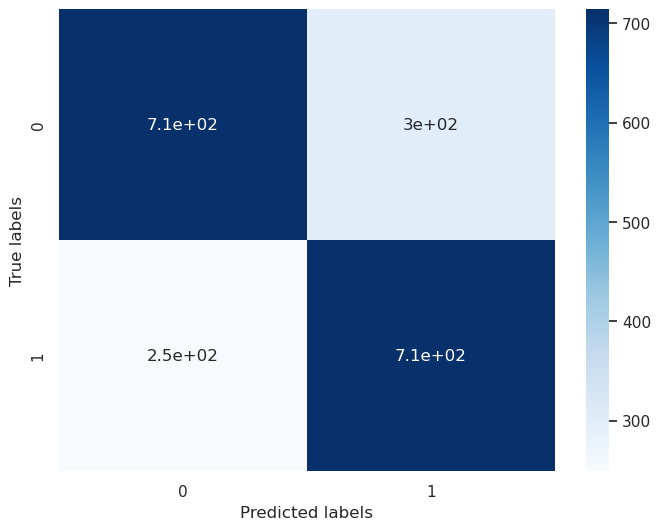

In [40]:
train_predict=clf.predict(x_train)
test_predict=clf.predict(x_test)
from sklearn import metrics

print('The accuracy of the LightGBM Classifier is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the LightGBM Classifier is',metrics.accuracy_score(y_test,test_predict))

confusion_matrix_result=metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

共有714+703个样本预测正确，300+249个样本预测错误

### Step7:利用 LightGBM 进行特征选择

<Axes: >

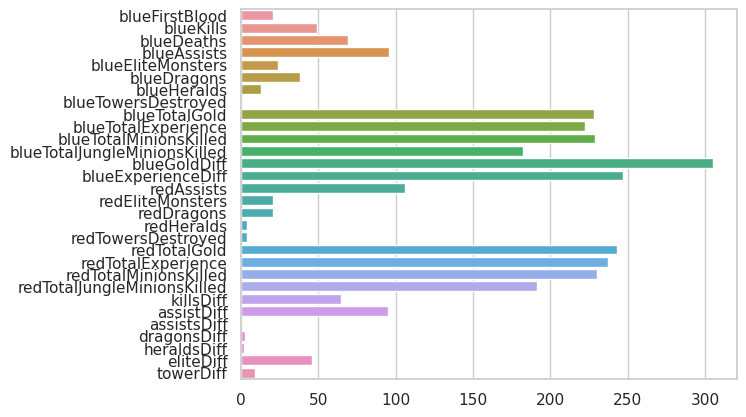

In [41]:
sns.barplot(y=data_features_part.columns, x=clf.feature_importances_)

总经济差距等特征，助攻数量、击杀死亡数量等特征都具有很大的作用。<br>
插眼数、推塔数对模型的影响并不大。

可以使用LightGBM中的下列重要属性来评估特征的重要性。

* gain:当利用特征做划分的时候的评价基尼指数
* split:是以特征用到的次数来评价

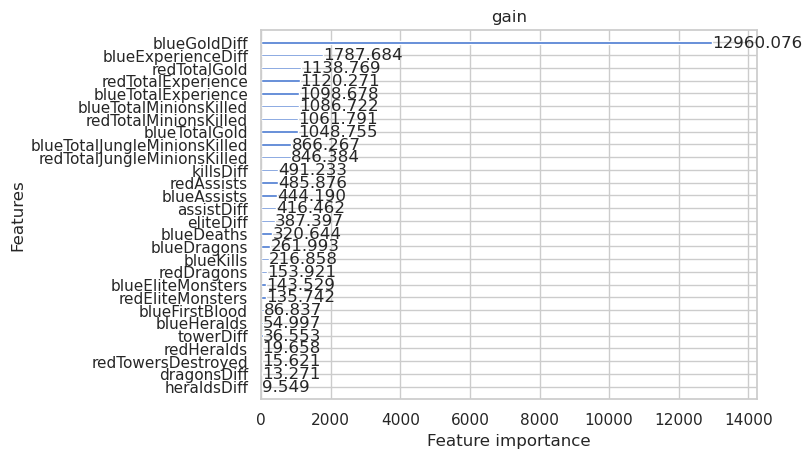

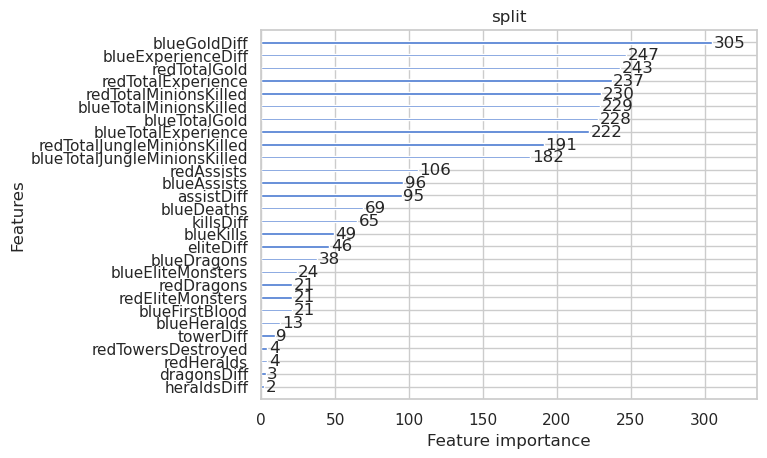

acc= 0.722165991902834


In [42]:
from sklearn.metrics import accuracy_score
from lightgbm import plot_importance

def estimate(model,data):

    #sns.barplot(data.columns,model.feature_importances_)
    ax1=plot_importance(model,importance_type="gain")
    ax1.set_title('gain')
    ax2=plot_importance(model, importance_type="split")
    ax2.set_title('split')
    plt.show()
def classes(data,label,test):
    model=LGBMClassifier()
    model.fit(data,label)
    ans=model.predict(test)
    estimate(model, data)
    return ans
 
ans=classes(x_train,y_train,x_test)
pre=accuracy_score(y_test, ans)
print('acc=',accuracy_score(y_test,ans))

LightGBM是一种梯度提升框架，它具有许多参数可供调整以优化模型性能。以下是LightGBM中一些重要的参数：

* `num_leaves`：树中的最大叶子节点数。较大的值可以提高模型的复杂性，但也可能导致过拟合。

* `learning_rate`：学习率控制每次迭代中模型权重的调整幅度。较小的学习率可以增加模型的稳定性，但可能需要更多的迭代次数才能达到最佳性能。

* `n_estimators`：迭代次数或弱学习器的数量。增加迭代次数可以提高模型性能，但也会增加训练时间。

* `max_depth`：树的最大深度。较小的值可以防止过拟合，但同时也可能损失模型的表达能力。

* `min_child_samples`：叶子节点上所需的最小样本数。较小的值可以提高模型的灵敏度，但也可能导致过拟合。

* `subsample`：用于训练每棵树的样本采样比例。较小的值可以防止过拟合，但也可能降低模型的性能。

* `colsample_bytree`：用于训练每棵树的特征采样比例。较小的值可以增加模型的稳定性，但可能降低模型的表达能力。

* `reg_alpha`：L1正则化项的权重。增加该值可以降低模型的复杂性。

* `reg_lambda`：L2正则化项的权重。增加该值可以降低模型的复杂性。

* `min_split_gain`：执行分裂的最小增益阈值。较小的值可以增加模型的灵敏度，但也可能导致过拟合。

### Step8:通过调整参数获得更好的效果

In [44]:
from sklearn.model_selection import GridSearchCV

## 定义参数取值范围
learning_rate = [0.1, 0.3, 0.6]
feature_fraction = [0.5, 0.8, 1]
num_leaves = [16, 32, 64]
max_depth = [-1,3,5,8]

parameters = { 'learning_rate': learning_rate,
              'feature_fraction':feature_fraction,
              'num_leaves': num_leaves,
              'max_depth': max_depth}
model = LGBMClassifier(n_estimators = 50)

## 进行网格搜索
clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy',verbose=3, n_jobs=-1)
clf = clf.fit(x_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[CV 1/3] END feature_fraction=0.5, learning_rate=0.1, max_depth=-1, num_leaves=16;, score=0.721 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[CV 2/3] END feature_fraction=0.5, learning_rate=0.1, max_depth=-1, num_leaves=16;, score=0.730 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[CV 3/3] END feature_fraction=0.5, learning_rate=0.1, max_depth=-1, num_leaves=16;, score=0.730 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[CV 1/3] END feature_fraction=0.5, learning_rate=0.1, max_depth=-1, num_leaves=32;, score=0.718 

In [45]:
## 网格搜索后的最好参数为

clf.best_params_

{'feature_fraction': 1, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 16}

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
The accuracy of the Logistic Regression is: 0.7462988738453752
The accuracy of the Logistic Regression is: 0.7302631578947368
The confusion matrix result:
 [[724 294]
 [239 719]]


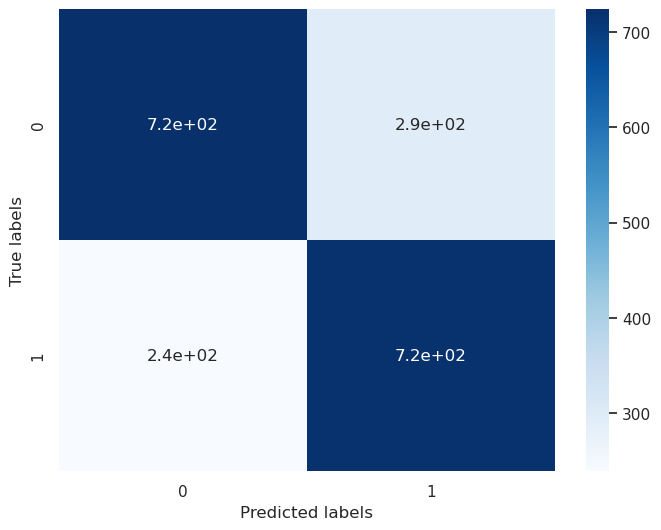

In [47]:
## 在训练集和测试集上分布利用最好的模型参数进行预测

## 定义带参数的 LightGBM模型 
clf = LGBMClassifier(feature_fraction = 1,
                    learning_rate = 0.1,
                    max_depth= 3,
                    num_leaves = 16)
# 在训练集上训练LightGBM模型
clf.fit(x_train, y_train)

train_predict = clf.predict(x_train)
test_predict = clf.predict(x_test)

## 利用accuracy（准确度）【预测正确的样本数目占总预测样本数目的比例】评估模型效果
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_train,train_predict))
print('The accuracy of the Logistic Regression is:',metrics.accuracy_score(y_test,test_predict))

## 查看混淆矩阵 (预测值和真实值的各类情况统计矩阵)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
print('The confusion matrix result:\n',confusion_matrix_result)

# 利用热力图对于结果进行可视化
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

原本共有714+703个样本预测正确，300 + 249个样本预测错误<br>
现在共有724+719个样本预测正确，239 + 294个样本预测错误<br>
明显正确率提升了

# LightGBM <br>
LightGBM是一个高效的梯度提升决策树（Gradient Boosting Decision Tree）框架，具有在大规模数据集和高维稀疏数据上训练和预测的优势。它通过垂直生长的决策树、直方图优化和并行计算等技术，实现了高效性和准确性的平衡。

## 基本原理

LightGBM的基本原理如下：

* `梯度提升决策树（GBDT）：`LightGBM基于梯度提升决策树。在GBDT中，每棵树是通过拟合之前所有树的残差来逐步构建的。这种迭代的过程将多个弱学习器（决策树）组合成强学习器，提高了预测性能。

* `垂直生长的决策树：`与传统的GBDT不同，LightGBM采用垂直生长的决策树构建方式。传统GBDT是水平生长的，一次只构建一个节点层级。而LightGBM采用垂直生长的方式，每次构建所有叶子节点。这种垂直生长的方式可以更好地利用内存和缓存，提高训练效率。

* `Leaf-wise叶子生长策略：`LightGBM使用Leaf-wise（叶子生长）策略进行决策树的生长。与传统GBDT的层次生长（level-wise）不同，Leaf-wise策略每次选择当前最佳的分割点来扩展叶子节点。这种策略可以更快地找到具有信息量的节点，但可能会导致过拟合。因此，LightGBM使用了最大深度和叶子数等参数限制来控制过拟合。

* `直方图优化：`为了进一步提高训练效率，LightGBM使用直方图优化来减少特征的离散化成本。它将连续的浮点特征值按照一定的精度进行离散化，并构建直方图来表示特征的分布。在训练过程中，LightGBM直接使用特征的直方图进行特征分裂，避免了对每个数据样本进行排序的开销。

* `并行计算：`LightGBM支持特征并行和数据并行两种并行方式。在特征并行中，特征被划分为不同的组，每个组上并行构建决策树。在数据并行中，数据集被划分为不同的子集，每个子集上并行构建决策树。这些并行策略可以加速训练过程，特别适用于大规模数据集。


## 目标函数和梯度计算公式

* 目标函数：<br>
![Objective Function](https://latex.codecogs.com/svg.latex?\mathcal{L}(\theta)%20=%20\sum_{i=1}^n%20l(y_i,%20\hat{y}_i)%20+%20\sum_{k=1}^K%20\Omega(f_k))

* 梯度计算：<br>
![Gradient Calculation](https://latex.codecogs.com/svg.latex?G_{ij}%20=%20\frac{\partial%20l(y_i,%20\hat{y}_i)}{\partial%20\hat{y}_i}%20\quad%20H_{ij}%20=%20\frac{\partial^2%20l(y_i,%20\hat{y}_i)}{\partial%20\hat{y}_i^2})

其中， $l$ 是损失函数， $y_i$ 是真实标签， $\hat{y}_i$ 是预测值， $f_k$ 是第 $k$ 棵树， $\Omega$ 是正则化项。

## LightGBM的重要参数
* `基本参数调整`
1.num_leaves参数 这是控制树模型复杂度的主要参数，一般的我们会使num_leaves小于（2的max_depth次方），以防止过拟合。由于LightGBM是leaf-wise建树与XGBoost的depth-wise建树方法不同，num_leaves比depth有更大的作用。

2.min_data_in_leaf 这是处理过拟合问题中一个非常重要的参数. 它的值取决于训练数据的样本个树和 num_leaves参数. 将其设置的较大可以避免生成一个过深的树, 但有可能导致欠拟合. 实际应用中, 对于大数据集, 设置其为几百或几千就足够了。

3.max_depth 树的深度，depth 的概念在 leaf-wise 树中并没有多大作用, 因为并不存在一个从 leaves 到 depth 的合理映射。

* `针对训练速度的参数调整`
通过设置 bagging_fraction 和 bagging_freq 参数来使用 bagging 方法。

通过设置 feature_fraction 参数来使用特征的子抽样。

选择较小的 max_bin 参数。

使用 save_binary 在未来的学习过程对数据加载进行加速。

* `针对准确率的参数调整`
使用较大的 max_bin （学习速度可能变慢）
使用较小的 learning_rate 和较大的 num_iterations
使用较大的 num_leaves （可能导致过拟合）
使用更大的训练数据
尝试 dart 模式

* `针对过拟合的参数调整`
使用较小的 max_bin
使用较小的 num_leaves
使用 min_data_in_leaf 和 min_sum_hessian_in_leaf
通过设置 bagging_fraction 和 bagging_freq 来使用 bagging
通过设置 feature_fraction 来使用特征子抽样
使用更大的训练数据
使用 lambda_l1, lambda_l2 和 min_gain_to_split 来使用正则
尝试 max_depth 来避免生成过深的树